# Testing the optimization run for convergence

In [59]:
import os
import tarfile
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rcParams
import seaborn as sns
import pandas as pd
import numpy as np

from ema_workbench.em_framework import ArchiveLogger, epsilon_nondominated
from ema_workbench import (HypervolumeMetric, GenerationalDistanceMetric)

In [46]:
# # sns.set(font_scale=1.2)

# fm.fontManager.addfont("Minion Pro Regular.ttf")
# matplotlib.rc("font", family="Minion Pro")

# rcParams["font.family"] = "Minion Pro"
# rcParams["font.sans-serif"] = "Minion Pro"
# rcParams["font.size"] = 12

## 1. Data colleciton

In [47]:
# Define the subfoldername of the experiment of interest
subfoldername = "nfe250000_None_bigger"
subfolderpath = f"outputs/{subfoldername}" 

In [48]:
results_filepath = f"{subfolderpath}/baseline_results_{subfoldername}.csv"
results = pd.read_csv(results_filepath, index_col=0)

In [49]:
results

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v160,v161,v162,v163,egypt_irr,egypt_90,egypt_low_had,sudan_irr,sudan_90,ethiopia_hydro
0,0.032622,0.902325,0.757990,0.394019,-0.420321,0.337028,-0.077204,0.168649,-0.754470,0.508633,...,0.973322,0.653731,0.490696,0.690960,4.708346,1.691684,0.141667,9.946539,1.706105,15.030984
1,0.230340,0.324657,0.870509,0.406127,-0.375333,0.294681,-0.057195,0.679724,0.210257,0.912921,...,0.090938,0.648512,0.872925,0.886020,3.846794,1.288469,0.158333,10.314356,1.565600,11.831712
2,0.155937,0.108416,0.848336,0.415178,-0.792735,0.298834,0.816544,0.072258,-0.380356,0.835108,...,0.326371,0.642027,0.558072,0.702756,5.077042,1.283620,0.754167,8.805921,1.446252,12.241481
3,0.443542,0.054469,0.424416,0.395787,0.612713,0.357304,0.732163,0.199344,0.259447,0.930249,...,0.274506,0.521315,0.683423,0.197016,4.967579,1.476072,0.400000,6.798282,1.467693,10.259496
4,0.374022,0.011169,0.067790,0.397445,-0.712304,0.415361,-0.081252,0.230011,-0.367298,0.504580,...,0.907527,0.468153,0.291172,0.341388,5.367931,1.861499,0.495833,5.975961,1.379873,11.067578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,0.458931,0.011048,0.696390,0.394138,-0.852067,0.683524,-0.042775,0.315586,-0.350110,0.165383,...,0.556404,0.117194,0.342069,0.890212,4.395644,1.489867,0.283333,7.617323,1.469091,9.452211
173,0.173292,0.264883,0.963510,0.410217,-0.807484,0.223243,0.032351,0.154523,-0.609151,0.174690,...,0.365857,0.068550,0.365032,0.233917,3.692827,1.284626,0.216667,10.632840,1.596565,12.097595
174,0.039918,0.262085,0.133754,0.385720,0.614173,0.313920,0.204703,0.142877,0.089131,0.989120,...,0.314694,0.490617,0.342630,0.169784,5.279238,1.743900,0.258333,7.639305,1.599628,15.025730
175,0.114763,0.903056,0.988737,0.384876,0.603123,0.368146,-0.056541,0.541688,-0.156181,0.271375,...,0.589330,0.497234,0.772673,0.797581,3.454759,1.013864,0.079167,10.681013,1.735744,14.319497


### 1.1 The model

In [50]:
def get_principle(s):
    for principle in ["None", "uwf", "pwf", "gini"]:
        if principle in s:
            return principle
    raise ValueError("Invalid string, principle not recognized.")

In [51]:
from experimentation import data_generation
from ema_workbench import Model, RealParameter, ScalarOutcome
from model.model_nile import ModelNile

principle = get_principle(subfoldername)

nile_model = ModelNile(principle=principle)
nile_model = data_generation.generate_input_data(nile_model, sim_horizon=20)

em_model = Model("NileProblem", function=nile_model)

parameter_count = nile_model.overarching_policy.get_total_parameter_count()
n_inputs = nile_model.overarching_policy.functions["release"].n_inputs
n_outputs = nile_model.overarching_policy.functions["release"].n_outputs
# RBF_count = nile_model.overarching_policy.functions["release"].RBF_count
p_per_RBF = 2 * n_inputs + n_outputs

lever_list = list()
for i in range(parameter_count):
    modulus = (i - n_outputs) % p_per_RBF
    if (
        (i >= n_outputs)
        and (modulus < (p_per_RBF - n_outputs))
        and (modulus % 2 == 0)
    ):  # centers:
        lever_list.append(RealParameter(f"v{i}", -1, 1))
    else:  # linear parameters for each release, radii and weights of RBFs:
        lever_list.append(RealParameter(f"v{i}", 0, 1))

em_model.levers = lever_list

# specify outcomes
em_model.outcomes = [
    ScalarOutcome("egypt_irr", ScalarOutcome.MINIMIZE),
    ScalarOutcome("egypt_90", ScalarOutcome.MINIMIZE),
    ScalarOutcome("egypt_low_had", ScalarOutcome.MINIMIZE),
    ScalarOutcome("sudan_irr", ScalarOutcome.MINIMIZE),
    ScalarOutcome("sudan_90", ScalarOutcome.MINIMIZE),
    ScalarOutcome("ethiopia_hydro", ScalarOutcome.MAXIMIZE),
]
if principle != "None":
    em_model.outcomes.extend(   # extend function used instead of append, since em_model.outcomes refers to an instance of the NamedObjectMap class
    ScalarOutcome("principle_result", ScalarOutcome.MAXIMIZE))

In [52]:
from ema_workbench.em_framework.optimization import epsilon_nondominated, to_problem
model = em_model
problem = to_problem(model, searchover="levers")

### 1.1 Epsilon progress

In [53]:
# Epsilon progress and archivelogs are already saved during the optimization
# Create the file path for the convergence CSV file
convergence_filepath = f"{subfolderpath}/baseline_convergence_{subfoldername}.csv"

In [54]:
# Read the CSV file into the convergence DataFrame
convergence = pd.read_csv(convergence_filepath, index_col=[0])
convergence

,epsilon_progress,nfe
0,0,0
1,25,100
2,538,12862
3,695,25582
4,774,38302
5,847,51022
6,978,64175
7,1019,77171
8,1040,90167
9,1070,103163


### 1.2 Hypervolume

In [55]:
# Intermediate results are archived in the 'archive.tar.gz' file which needs to be unpacked
archive_directory = f"{subfolderpath}/archive_logs/tmp"
archive_log_directory = f"{subfolderpath}/archive_logs"

In [65]:
all_archives = []

archives = ArchiveLogger.load_archives(f"{archive_log_directory}/archives.tar.gz")

# Removing the "Unnamed: 0" column from each DataFrame in the dictionary
for key, df in archives.items():
    archives[key] = df.drop(columns=["Unnamed: 0"])

all_archives.append(archives)
# for different seeds 
# for i in range(5):
#     archives = ArchiveLogger.load_archives(f"{subfolderpath}/archive_logs/archives.tar.gz")
#     all_archives.append(archives)

In [57]:
print(f"Total number of archives: {len(all_archives)}")
for index, archive in enumerate(all_archives, 1):
    print(f"Archive {index}: {len(archive)} items")

Total number of archives: 1
Archive 1: 22 items


In [64]:
# Displaying the first item from the first archive
if all_archives and all_archives[0]:
    print("\nFirst item from the first archive:")
    print(all_archives[0][0])


First item from the first archive:
Empty DataFrame
Columns: [Unnamed: 0, v0, v1, v2, v3, v4, v5, v6, v7, v8, v9, v10, v11, v12, v13, v14, v15, v16, v17, v18, v19, v20, v21, v22, v23, v24, v25, v26, v27, v28, v29, v30, v31, v32, v33, v34, v35, v36, v37, v38, v39, v40, v41, v42, v43, v44, v45, v46, v47, v48, v49, v50, v51, v52, v53, v54, v55, v56, v57, v58, v59, v60, v61, v62, v63, v64, v65, v66, v67, v68, v69, v70, v71, v72, v73, v74, v75, v76, v77, v78, v79, v80, v81, v82, v83, v84, v85, v86, v87, v88, v89, v90, v91, v92, v93, v94, v95, v96, v97, v98, ...]
Index: []

[0 rows x 171 columns]


## 2 Convergence resultst

In [61]:
hv = HypervolumeMetric(results, problem)
gd = GenerationalDistanceMetric(results, problem, d=1)

In [67]:
from tqdm import tqdm

for archives in all_archives:
    metrics = []
    for nfe, archive in tqdm(archives.items(), desc="Processing NFEs"):
        scores = {
            "generational_distance": gd.calculate(archive),
            "hypervolume": hv.calculate(archive),
            "nfe": int(nfe)
            }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

Processing NFEs: 100%|██████████| 22/22 [17:20<00:00, 47.31s/it]


In [71]:
# sort metrics by number of function evaluations
metrics_by_seed = []
metrics.sort_values(by="nfe", inplace=True)
metrics_by_seed.append(metrics)

In [75]:
convergences = []
convergences.append(convergence)

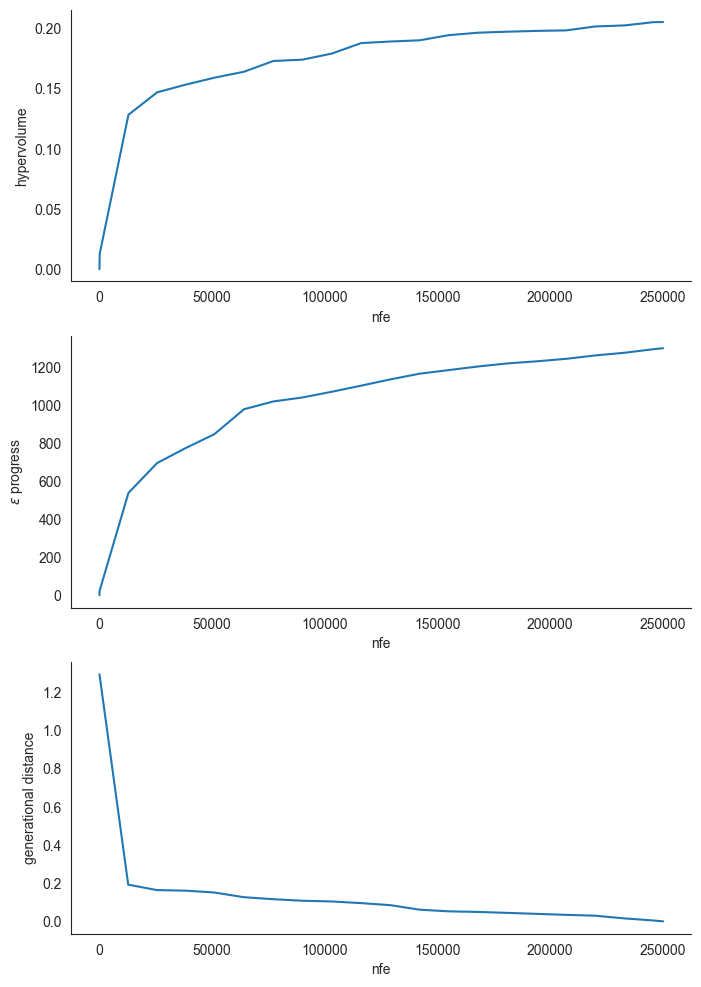

In [79]:
sns.set_style("white")
fig, axes = plt.subplots(nrows=3, figsize=(8, 12), sharex=False)

ax1, ax2, ax3 = axes

for metrics, convergence in zip(metrics_by_seed, convergences):
    ax1.plot(metrics.nfe, metrics.hypervolume)
    ax1.set_ylabel("hypervolume")

    ax2.plot(convergence.nfe, convergence.epsilon_progress)
    ax2.set_ylabel("$\epsilon$ progress")

    ax3.plot(metrics.nfe, metrics.generational_distance)
    ax3.set_ylabel("generational distance")

for ax in axes:
    ax.set_xlabel("nfe")

sns.despine(fig)

plt.show()